# 第5章 决策树
1．分类决策树模型是表示基于特征对实例进行分类的树形结构。决策树可以转换成一个if-then规则的集合，也可以看作是定义在特征空间划分上的类的条件概率分布。

2．决策树学习旨在构建一个与训练数据拟合很好，并且复杂度小的决策树。因为从可能的决策树中直接选取最优决策树是NP完全问题。现实中采用启发式方法学习次优的决策树。

决策树学习算法包括3部分：特征选择、树的生成和树的剪枝。常用的算法有ID3、 C4.5和CART。

3．特征选择的目的在于选取对训练数据能够分类的特征。特征选择的关键是其准则。常用的准则如下：

###### （1）样本集合$D$对特征$A$的信息增益（ID3）

$$g(D, A)=H(D)-H(D|A)$$$$H(D)=-\sum_{k=1}^{K} \frac{\left|C_{k}\right|}{|D|} \log _{2} \frac{\left|C_{k}\right|}{|D|}$$$$H(D | A)=\sum_{i=1}^{n} \frac{\left|D_{i}\right|}{|D|} H\left(D_{i}\right)$$
其中，$H(D)$是数据集$D$的熵，$H(D_i)$是数据集$D_i$的熵，$H(D|A)$是数据集$D$对特征$A$的条件熵。 $D_i$是$D$中特征$A$取第$i$个值的样本子集，$C_k$是$D$中属于第$k$类的样本子集。$n$是特征$A$取 值的个数，$K$是类的个数。

###### （2）样本集合$D$对特征$A$的信息增益比（C4.5）

$$g_{R}(D, A)=\frac{g(D, A)}{H(D)}$$
其中，$g(D,A)$是信息增益，$H(D)$是数据集$D$的熵。

###### （3）样本集合$D$的基尼指数（CART）

$$\operatorname{Gini}(D)=1-\sum_{k=1}^{K}\left(\frac{\left|C_{k}\right|}{|D|}\right)^{2}$$
特征$A$条件下集合$D$的基尼指数：

$$\operatorname{Gini}(D, A)=\frac{\left|D_{1}\right|}{|D|} \operatorname{Gini}\left(D_{1}\right)+\frac{\left|D_{2}\right|}{|D|} \operatorname{Gini}\left(D_{2}\right)$$

4．决策树的生成。通常使用信息增益最大、信息增益比最大或基尼指数最小作为特征选择的准则。决策树的生成往往通过计算信息增益或其他指标，从根结点开始，递归地产生决策树。这相当于用信息增益或其他准则不断地选取局部最优的特征，或将训练集分割为能够基本正确分类的子集。

5．决策树的剪枝。由于生成的决策树存在过拟合问题，需要对它进行剪枝，以简化学到的决策树。决策树的剪枝，往往从已生成的树上剪掉一些叶结点或叶结点以上的子树，并将其父结点或根结点作为新的叶结点，从而简化生成的决策树。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from collections import Counter
import math
from math import log
import pprint

## 书上题目5.1

In [2]:
def create_data():
    datasets = [
               ['青年', '否', '否', '一般', '否'],
               ['青年', '否', '否', '好', '否'],
               ['青年', '是', '否', '好', '是'],
               ['青年', '是', '是', '一般', '是'],
               ['青年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '一般', '否'],
               ['中年', '否', '否', '好', '否'],
               ['中年', '是', '是', '好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['中年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '非常好', '是'],
               ['老年', '否', '是', '好', '是'],
               ['老年', '是', '否', '好', '是'],
               ['老年', '是', '否', '非常好', '是'],
               ['老年', '否', '否', '一般', '否'],
               ]
    labels = [u'年龄', u'有工作', u'有自己的房子', u'信贷情况', u'类别']
    # 返回数据集和每个维度的名称
    return datasets, labels

In [3]:
datasets, labels = create_data()

In [4]:
train_data = pd.DataFrame(datasets, columns=labels)

In [5]:
# 经验熵H(D)
def calc_ent(datasets):
    data_length = len(datasets)
    label_count = {}
    for i in range(data_length):
        label = datasets[i][-1]
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += 1
    ent = -sum(
               [(p / data_length) * log(p / data_length, 2) for p in label_count.values()]
               )
    return ent
# def entropy(y):
#     """
#     Entropy of a label sequence
#     """
#     hist = np.bincount(y)
#     ps = hist / np.sum(hist)
#     return -np.sum([p * np.log2(p) for p in ps if p > 0])


# 经验条件熵H(D\A)
def cond_ent(datasets, label=0):    # label可取0、1、2、3，分别代表A1、A2、A3、A4的那一列
    data_length = len(datasets)
    feature_sets = {}
    for i in range(data_length):
        feature = datasets[i][label]
        if feature not in feature_sets:
            feature_sets[feature] = []
        feature_sets[feature].append(datasets[i]) 
        # 默认按照A1计算经验条件熵，feature_sets是一个字典，为：{"青年":[['青年', '否', '否', '一般', '否']，...],"中年":[...],"老年":[...]}
    cond_ent = sum(
                   [(len(p) / data_length) * calc_ent(p) for p in feature_sets.values()]
                   )
    return cond_ent


# 信息增益
def info_gain(ent, cond_ent):
    return ent - cond_ent


def info_gain_train(datasets):
    count = len(datasets[0]) - 1      # datasets[0]是第一行数据，len(datasets[0])-1就是4
    ent = calc_ent(datasets)
    # ent = entropy(datasets)
    best_feature = []
    for c in range(count):
        c_info_gain = info_gain(ent, cond_ent(datasets, label=c))
        best_feature.append((c, c_info_gain))
        print('特征“{}”的信息增益为：{:.3f}'.format(labels[c], c_info_gain))
    # 比较大小
    best_ = max(best_feature, key=lambda x: x[-1])
    return '特征“{}”的信息增益最大，选择为根节点特征'.format(labels[best_[0]])

In [6]:
info_gain_train(datasets)

特征“年龄”的信息增益为：0.083
特征“有工作”的信息增益为：0.324
特征“有自己的房子”的信息增益为：0.420
特征“信贷情况”的信息增益为：0.363


'特征“有自己的房子”的信息增益最大，选择为根节点特征'

## 例5.3：利用ID3算法生成决策树

In [7]:
# 熵
def calc_ent(datasets):
    data_length = len(datasets)
    label_count = {}
    for i in range(data_length):
        label = datasets[i][-1]
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += 1
    ent = -sum([(p / data_length) * log(p / data_length, 2) for p in label_count.values()])
    return ent

# 经验条件熵
def cond_ent(self, datasets, axis=0):
    data_length = len(datasets)
    feature_sets = {}
    for i in range(data_length):
        feature = datasets[i][axis]
        if feature not in feature_sets:
            feature_sets[feature] = []
        feature_sets[feature].append(datasets[i])
    cond_ent = sum([(len(p) / data_length) * self.calc_ent(p) for p in feature_sets.values()])
    return cond_ent

# 信息增益
def info_gain(ent, cond_ent):
    return ent - cond_ent

def info_gain_train(self, datasets):
    count = len(datasets[0]) - 1
    ent = self.calc_ent(datasets)
    best_feature = []
    for c in range(count):
        c_info_gain = self.info_gain(ent, self.cond_ent(datasets, axis=c))
        best_feature.append((c, c_info_gain))
    # 比较大小
    best_ = max(best_feature, key=lambda x: x[-1])
    return best_

def majorityCnt(classList):    #按分类后类别数量排序，比如：最后分类为2男1女，则判定为男；
    classCount={}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote]=0
        classCount[vote]+=1
    sortedClassCount = sorted(classCount.items(),key=operator.itemgetter(1),reverse=True)
    return sortedClassCount[0][0]

In [8]:
datasets, labels = create_data()
data_df = pd.DataFrame(datasets, columns=labels)
dt = DecisionTree()
tree = dt.fit(data_df)

In [9]:
tree

{'label': None, 'feature': '有自己的房子', 'tree': {'否': {'label': None, 'feature': '有工作', 'tree': {'否': {'label': '否', 'feature': None, 'tree': {}}, '是': {'label': '是', 'feature': None, 'tree': {}}}}, '是': {'label': '是', 'feature': None, 'tree': {}}}}

In [10]:
dt.predict(['老年', '否', '否', '一般'])

TypeError: list indices must be integers or slices, not str

## scikit-learn实例

In [33]:
X_train = train_data.iloc[:,0:train_data.shape[1]-1]
y_train = train_data.iloc[:,-1]

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn  import preprocessing
from sklearn.tree import export_graphviz
import graphviz

In [60]:
# 数据预处理
le_X = preprocessing.LabelEncoder().fit(np.unique(X_train))
X_train = X_train.apply(le_X.transform)

le_y = preprocessing.LabelEncoder().fit(y_train)
y_train = le_y.transform(y_train)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [61]:
X_new = pd.DataFrame([["青年","否","是","一般"]])
X = X_new.apply(le_X.transform)
y_predict = clf.predict(X)
print(y_predict)                       # 未知原因出现错误，pycharm未报错

ValueError: y contains previously unseen labels: '青年'

In [62]:
tree_pic = export_graphviz(clf, out_file="mytree.pdf")
with open('mytree.pdf') as f:
    dot_graph = f.read()

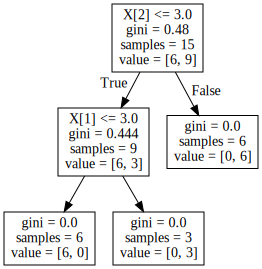

In [63]:
graphviz.Source(dot_graph)